# 1. Setup

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=2dc426fbfd26901ea10fa8c62092c4b979c48232313d3b5180f43bc52c96c6c6
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import dependencies
# Here we load the packages that we need for the rest of the practical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import torch 
import torch.nn as nn
import time
import torch.nn.functional as F # Contains some additional functions such as activations
from torch.autograd import Variable
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import math
import medmnist
from medmnist import INFO
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import torch.utils.data as data
import cv2

In [5]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


Some Helper

In [6]:
def plot_bar(x, y, description):
    fig, ax = plt.subplots()
    ax.bar(y, x)
    ax.set_xlabel(description)
    ax.set_ylabel('Number of Images')
    ax.set_title('Distribution of ' + description)
    plt.show()

In [7]:
def plot_loss_acc(losses, max_epochs):
  losses = np.array(losses).T
  epochs = np.linspace(1, max_epochs, max_epochs)

  plt.figure(figsize=(10, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs, losses[0,:])
  plt.plot(epochs, losses[2,:])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.subplot(1,2,2)
  plt.plot(epochs, losses[1,:])
  plt.plot(epochs, losses[3,:])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])
  plt.show()

# Data Pre-processing

## Load Data

In [8]:
# First we load the data
dataset = np.load('/content/drive/MyDrive/DR-Solution/Data/retinamnist.npz')
data = {'train': dataset['train_images'], 'test': dataset['test_images'], 'val': dataset['val_images']}
labels = {'train':  dataset['train_labels'], 'test': dataset['test_labels'], 'val': dataset['val_labels']}
classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']

In [9]:
data_flag = 'retinamnist'
info = INFO[data_flag]
task = info['task']

## Params

In [29]:
Params = {
    'n_channels' : info['n_channels'],
    'n_classes' : len(info['label']),
    'n_Epochs' : 30,
    'BATCH_SIZE' : 128,
    'lr' : 0.001,
    'input_d': 112,
    'hidden_d': 128,
    'n_fc': 4,
    'stop' : 10,
    'weights': ResNet50_Weights.DEFAULT,
}

## Examine Data

### Data Shape

In [12]:
print("Shape of data:", data['train'][0].shape)

Shape of data: (28, 28, 3)


### Data Balance

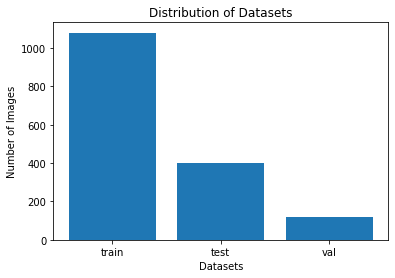

In [13]:
plot_bar([len(data['train']), len(data['test']), len(data['val'])], ['train', 'test', 'val'], 'Datasets')

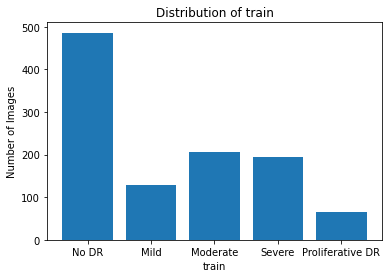

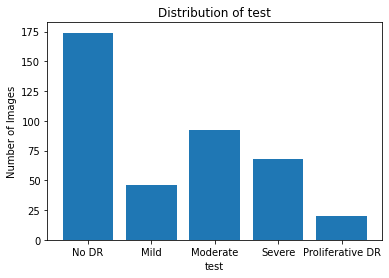

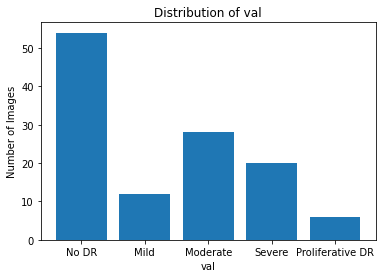

In [14]:
for split in labels:
    distribution = []
    for i in range(len(classes)):
        c = classes[i]
        examples = [example for example in labels[split] if example == i]
        distribution.append(len(examples))
    plot_bar(distribution, classes, split)

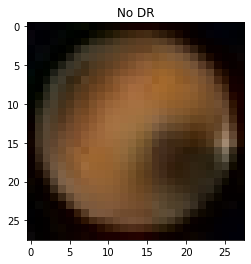

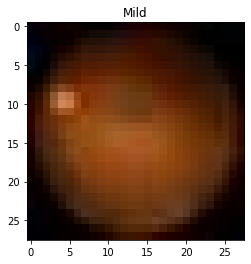

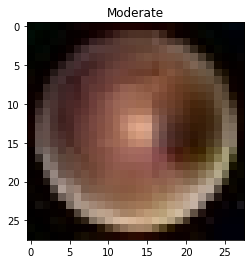

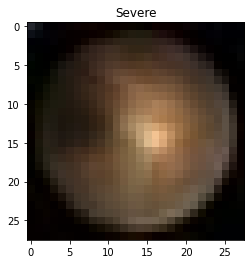

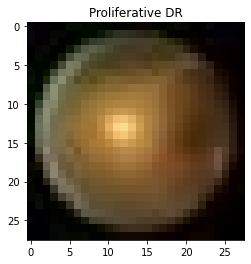

In [15]:
# Display the image
for j in range(len(classes)):
    i = 0
    while labels['train'][i] != j:
      i+=1
    plt.title(classes[j])
    plt.imshow(data['train'][i], interpolation='nearest')
    plt.show()

## Apply CLACHE

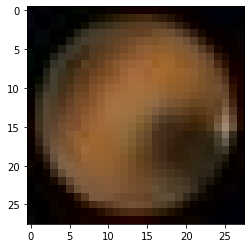

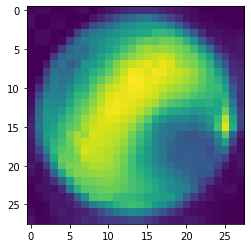

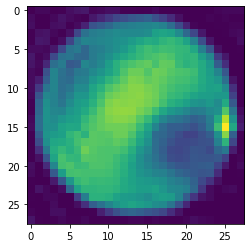

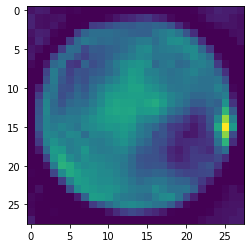

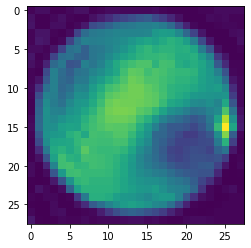

(28, 28, 3)


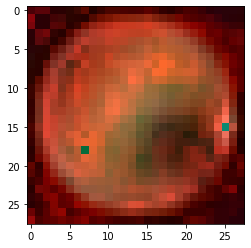

In [16]:
image = data['train'][0]
plt.imshow(image)
plt.show()
plt.imshow(image[:,:,0])
plt.show()
plt.imshow(image[:,:,1])
plt.show()
plt.imshow(image[:,:,2])
plt.show()
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_bw)
plt.show()
 
# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit = 5)
final_img = np.array([clahe.apply(image[:,:,i]) + 10 if i == 0 else image[:, :, i] for i in range(3)])
final_img = np.transpose(final_img, (1, 2, 0))
print(final_img.shape)
plt.imshow(final_img)

In [17]:
def apply_clache(img):
  clahe = cv2.createCLAHE(clipLimit = 5)
  out_img = np.transpose(np.array([clahe.apply(img[:,:,i]) + 10 for i in range(3)]), (1, 2, 0))
  return out_img

## Normalizing

In [18]:
data_transform = transforms.Compose([
    apply_clache,
    transforms.ToTensor(),
    Params['weights'].transforms(),
    transforms.Normalize(mean=[0.43, 0.41, 0.39], std=[0.229, 0.224, 0.225]),
])
def to_one_hot(y, num_classes):
    y = y.squeeze()
    store = np.eye(num_classes)[y]
    return store

In [19]:
class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, input_data, target, transform = None):
        self.data = input_data
        self.target = torch.from_numpy(to_one_hot(target, Params['n_classes'])).to(torch.float32)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        if self.transform:
            x = self.transform(self.data[index])
        return x, y

    def __len__(self):
        return len(self.data)

In [30]:
train_dataset = numpy_dataset(data['train'], labels['train'], transform = data_transform)
val_dataset = numpy_dataset(data['val'], labels['val'], transform = data_transform)
train_dataloader = DataLoader(train_dataset, batch_size=Params['BATCH_SIZE'], shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

Train batch shape: (32, 3, 224, 224)
Train label shape: (32, 5)
Train batch mean across channels: [-0.3894497  -0.45690876 -0.31130055]
Train batch std across channels: [3.629223  3.8331134 3.882568 ]


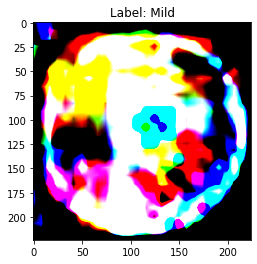

In [21]:
sample = next(iter(train_dataloader))
train_sample = sample[0].numpy()
train_label = sample[1].numpy()
print("Train batch shape:", train_sample.shape)
print("Train label shape:", train_label.shape)
print("Train batch mean across channels:", np.mean(train_sample, axis = (0, 2, 3)))
print("Train batch std across channels:", np.std(train_sample, axis = (0, 2, 3)))
plt.title("Label: " + classes[np.argmin(train_label[0])])
plt.imshow(np.transpose(train_sample[0], (1, 2, 0)), interpolation='nearest')
plt.show()

Text(0.5, 0, 'Intensity Value')

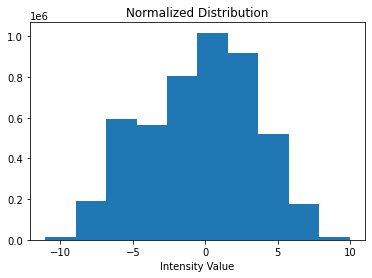

In [22]:
plt.hist(train_sample.flatten())
plt.title('Normalized Distribution')
plt.xlabel('Intensity Value')

# Model

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Transfer Learning with Resnet50

In [24]:
pt_res = resnet50(weights = Params['weights'])
for param in pt_res.parameters():
    param.requires_grad = False
pt_res_out = pt_res.fc.out_features

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Model Implementation

In [25]:
class net(nn.Module):
    def __init__(self, pt_model = pt_res,
                 fc_input_d = pt_res_out,
                 output_d = Params['n_classes'],
                 hidden_d = Params['hidden_d'],
                 num_layers = Params['n_fc']):

        super(net, self).__init__()
        self.pt_model = pt_model
        self.fc_input_d = fc_input_d
        self.fc = nn.ModuleList([nn.Linear(
                self.fc_input_d if layer == 0 else hidden_d,
                output_d if layer == num_layers - 1 else hidden_d,
            )for layer in range(num_layers)])
        self.relu = nn.ReLU(inplace=True)
        self.activate = nn.Sigmoid()

    def forward(self, images):
        model = self.pt_model
        features = model(images)
        for (index, layer) in enumerate(self.fc):
            features = layer(features)
            if index < len(self.fc)-1:
                features = self.relu(features)
        out = self.activate(features)
        return out

### Test run

In [26]:
test_net = net()
test_output = test_net(torch.tensor(train_sample))
print("The size of test_output is {}".format(tuple(test_output.shape)))

The size of test_output is (32, 5)


#Experiment

In [27]:
from sklearn.metrics import accuracy_score

def run(run_net, dataloader, run_optim, loss_func, curr_epoch, mode ='train'):
    run_net = run_net.to(device)
    loss_func = loss_func.to(device)
    total_loss = 0
    pred_store = []
    true_store = []
    batches = 0
    t0 = time.time()
    if mode == 'train':
        run_net.train()
        for batch_idx, (batch_data, target) in enumerate(dataloader):

            batch_data, target = Variable(batch_data), Variable(target)
            batches += 1
            inputs = batch_data.to(device)
            output_labels = target.to(device)
            run_optim.zero_grad()
            pred = run_net(inputs)
            loss = loss_func(pred, output_labels)
            loss.backward()
            run_optim.step()
            total_loss += loss
            pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
            true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))

        if batch_idx % 100 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    curr_epoch, (batch_idx + 1) * len(batch_data), len(dataloader.dataset),
                                100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
        t1 = time.time()

        av_loss = total_loss / batches
        total_time = t1-t0
        print('Time for epoch = ', total_time)

    elif mode == 'validate':
        run_net.eval()
        with torch.no_grad():  # So no gradients accumulate
            for batch_idx, (batch_data, target) in enumerate(val_dataloader):
                batches += 1
                batch_data, target = Variable(batch_data), Variable(target)
                inputs = batch_data.to(device)
                output_labels = target.to(device)
                pred = run_net(inputs)
                loss = loss_func(pred, output_labels)
                total_loss += loss
                pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
                true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))
            av_loss = total_loss / batches

    else:
        run_net.eval()
        with torch.no_grad():  # So no gradients accumulate
            for batch_idx, (batch_data, target) in enumerate(val_dataloader):
                batches += 1
                batch_data, target = Variable(batch_data), Variable(target)
                inputs = batch_data.to(device)
                pred = run_net(inputs)
                pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
                true_store.append(np.argmax(target.detach().cpu().numpy(), axis=1))
            av_loss = 0

    av_loss = av_loss.detach().cpu().numpy()
    pred_store = np.array(pred_store).reshape(-1)
    true_store = np.array(true_store).reshape(-1)
    acc = accuracy_score(pred_store, true_store)

    print(mode + ' set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print(mode + ' set: Average Acc: {:.4f}'.format(acc,  flush=True))
    print('\n')

    return av_loss, acc

### Show Results

Time for epoch =  5.1869916915893555
train set: Average loss: 1.5730
train set: Average Acc: 0.4189


validate set: Average loss: 1.5124
validate set: Average Acc: 0.4583


Time for epoch =  5.988243103027344
train set: Average loss: 1.4668
train set: Average Acc: 0.4502


validate set: Average loss: 1.4293
validate set: Average Acc: 0.4583


Time for epoch =  5.150538682937622
train set: Average loss: 1.4304
train set: Average Acc: 0.4541


validate set: Average loss: 1.4261
validate set: Average Acc: 0.4583


Time for epoch =  5.825965166091919
train set: Average loss: 1.4272
train set: Average Acc: 0.4473


validate set: Average loss: 1.4066
validate set: Average Acc: 0.4583


Time for epoch =  5.950610399246216
train set: Average loss: 1.4100
train set: Average Acc: 0.4512


validate set: Average loss: 1.3950
validate set: Average Acc: 0.4583


Time for epoch =  5.687340497970581
train set: Average loss: 1.3903
train set: Average Acc: 0.4600


validate set: Average loss: 1.3599
val

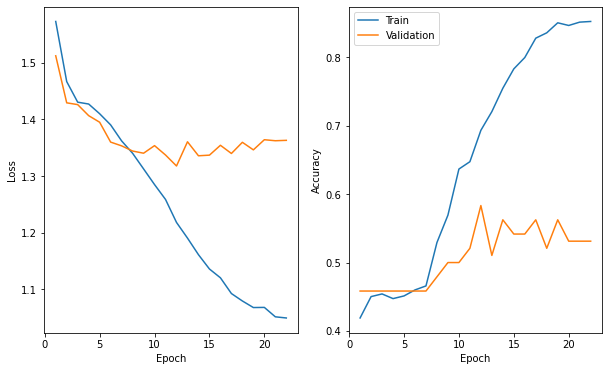

In [31]:
DRnet = net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(DRnet.parameters(), lr = Params['lr'])
patience = Params['stop']
best_val_loss = float('inf')
losses = []
max_epochs = Params['n_Epochs']
num_epochs_since_best = 0
end_epoch = max_epochs
for epoch in range(1, max_epochs+1):
    train_loss, train_acc = run(DRnet, train_dataloader, optimizer, criterion, epoch, mode = "train")
    val_loss, val_acc = run(DRnet, val_dataloader, optimizer, criterion, epoch, mode = "validate")
    losses.append([train_loss, train_acc, val_loss, val_acc])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_since_best = 0
    else:
        num_epochs_since_best += 1
    if num_epochs_since_best >= patience:
        print(f"Validation loss has not improved for {patience} epochs, stopping training.")
        end_epoch = epoch
        break
plot_loss_acc(losses, end_epoch)